In [1]:
# Libraries used
import numpy as np
import pandas as pd
import plotly.express as px
import yfinance as yf
from yahoofinancials import YahooFinancials
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import scipy.stats as stats
import esig.tosig as ts
from sklearn.metrics import r2_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

tf.config.set_visible_devices([], 'GPU')

2024-01-19 21:45:00.089212: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-19 21:45:00.114778: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-19 21:45:00.578105: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-01-19 21:45:01.022297: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.

# Fetching data

In [2]:
ticker = 'AAPL'
yahoo_financials = YahooFinancials(ticker)
historical_stock_prices = yahoo_financials.get_historical_price_data('2023-01-01', '2023-12-31', 'daily')

In [3]:
prices = pd.DataFrame(historical_stock_prices[ticker]['prices'])
prices.set_index('formatted_date', inplace=True)
prices.index.name = 'Date'

# Data featuring

In [4]:
log_s = np.log(prices['adjclose'])[:-62]
log_v = np.log(prices['volume'])[:-62]
log_vol = np.log(prices['adjclose'].rolling(63).std()).dropna()

In [5]:
# Setting the hyperparameters
L = 5
M = 2
lambda_value = 1.0

In [6]:
# path calculation
z = []
for t in range(L, log_s.shape[0]):
    path_s = log_s[t-L:t]
    path_v = log_v[t-L:t]
    path_vol = log_vol[t-L:t]
    
    z.append(np.array([(t-L+tau, path_s[tau], path_v[tau], path_vol[tau]) for tau in range(L)]))


In [7]:
# signature transformation calculation
x = np.array([ts.stream2sig(zt, M) for zt in z])

In [8]:
x = x[:, :, np.newaxis]
y = log_s[L:]

In [9]:
# Splittting the data
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, shuffle=False)

# Setting architecture

In [10]:
# Regularisation for direct learning
def custom_regularization_term(weights, lambda_value):
    squared_value = tf.square(weights)
    return lambda_value * tf.reduce_sum(squared_value)

# Regularisation for transfer learning
def custom_loss(y_true, y_pred, lambda_value):
    mse_loss = MeanSquaredError()(y_true, y_pred)
    reg_loss = custom_regularization_term(model.trainable_weights[0], lambda_value)
    return mse_loss + reg_loss

In [11]:
# Inicialisation of NN
model = Sequential()  
model.add(LSTM(69, activation="tanh", recurrent_activation='sigmoid', return_sequences=True, 
               input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(LSTM(3, activation="tanh", return_sequences=True))
model.add(LSTM(98, activation="tanh", return_sequences=True))


# Dense layer
model.add(Dense(98, activation='tanh'))

model.add(LSTM(6, activation="tanh"))
# Last layer
model.add(Dense(1))

2024-01-19 21:45:01.443296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-19 21:45:01.443879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-19 21:45:01.444777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [12]:
# model compilation
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, lambda_value),
              metrics=['mse'])

In [13]:
# Model fitting
history = model.fit(X_train, y_train, 
                    epochs=200, batch_size=30, validation_split=0.1, verbose=0)

2024-01-19 21:45:01.906757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-19 21:45:01.907810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-19 21:45:01.908408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2024-01-19 21:45:04.578192: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7feae402a600 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-01-19 21:45:04.578221: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Host, Default Version
2024-01-19 21:45:04.581100: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-19 21:45:04.598141: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-01-19 21:45:05.167039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dt

In [14]:
# Model prediction
y_pred = model.predict(X_test)

2024-01-19 21:45:25.416391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-19 21:45:25.417153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-19 21:45:25.417899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 8ms/step


In [15]:
print('Mean Squared Error:',mean_squared_error(y_pred, y_test))

Mean Squared Error: 0.024452112096449048


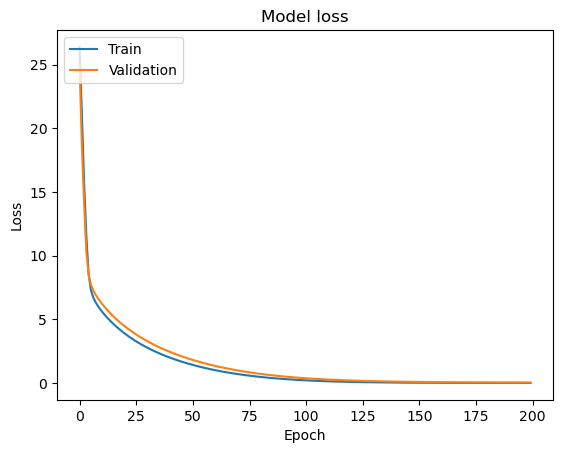

In [16]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()